# Trailer: Biobildanalyse mit Python
In den folgenden Kapiteln werden wir uns in die Bildanalyse, maschinelles Lernen und Biostatistik mit Python vertiefen. Dieses erste Notebook dient als Vorschau auf das, was wir machen werden.

Python-Notebooks beginnen typischerweise mit den Importen der Python-Bibliotheken, die das Notebook verwenden wird. Der Leser kann zunächst überprüfen, ob all diese Bibliotheken installiert sind, bevor er das gesamte Notebook durchgeht.

In [1]:
import numpy as np
from skimage.io import imread, imshow
import pyclesperanto_prototype as cle
from skimage import measure
import pandas as pd
import seaborn
import apoc
import stackview

## Arbeiten mit Bilddaten
Wir beginnen mit dem Laden der interessierenden Bilddaten. In diesem Beispiel laden wir ein Bild, das ein Zebrafischauge zeigt, mit freundlicher Genehmigung von Mauricio Rocha Martins, Norden-Labor, MPI CBG Dresden.

StackViewNDArray([[14709, 17195, 15101, ..., 10977, 10615, 10864],
                  [15234, 16786, 16048, ..., 11350, 11110, 11061],
                  [15709, 15896, 16645, ..., 11334, 10853, 10584],
                  ...,
                  [22707, 22025, 23783, ..., 16773, 17757, 16991],
                  [22484, 24699, 21860, ..., 16546, 16348, 17791],
                  [23357, 21872, 23148, ..., 18280, 18107, 17240]],
                 dtype=uint16)
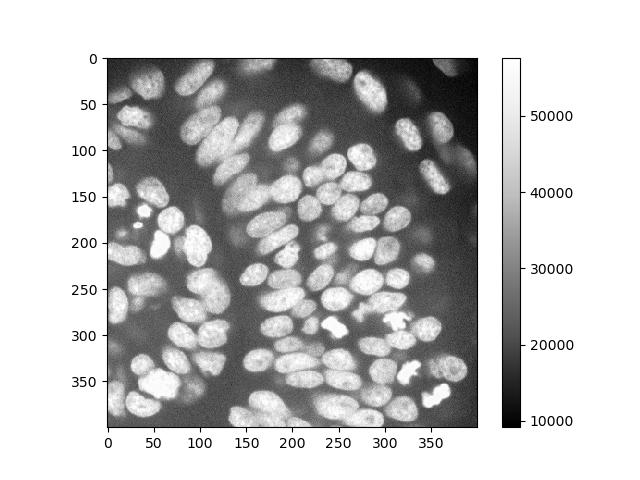
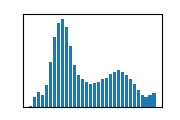

In [2]:
# open an image file
multichannel_image = imread("../../data/zfish_eye.tif")

# extract a channel
single_channel_image = multichannel_image[:,:,0]

cropped_image = single_channel_image[200:600, 500:900]

stackview.insight(cropped_image)

## Bildfilterung

Ein üblicher Schritt bei der Arbeit mit Fluoreszenz-Mikroskopiebildern ist das Subtrahieren der Hintergrundintensität, z.B. resultierend aus unfokussiertem Licht. Dies kann die Bildsegmentierungsergebnisse weiter unten im Workflow verbessern.

StackViewNDArray([[1279., 3765., 1671., ..., 1790., 1428., 1677.],
                  [1804., 3356., 2618., ..., 2163., 1923., 1874.],
                  [2279., 2466., 3215., ..., 2147., 1666., 1397.],
                  ...,
                  [1608.,  926., 2684., ..., 1342., 2326., 1560.],
                  [1385., 3600.,  761., ..., 1115.,  917., 2360.],
                  [2280.,  795., 2071., ..., 2849., 2676., 1809.]],
                 dtype=float32)
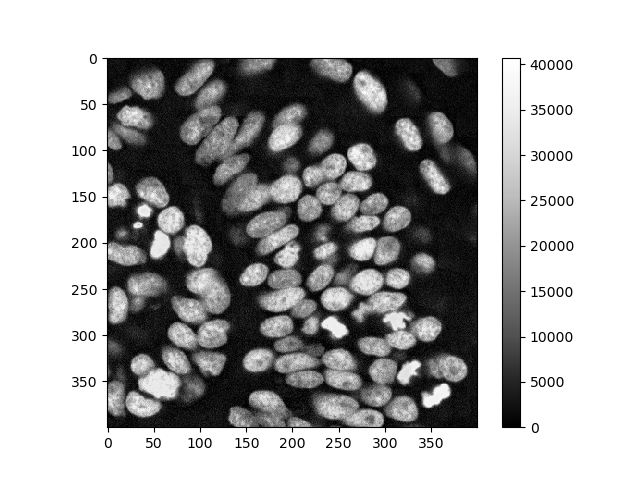
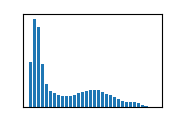

In [3]:
# subtract background using a top-hat filter
background_subtracted_image = cle.top_hat_box(cropped_image, radius_x=20, radius_y=20)

stackview.insight(background_subtracted_image)

## Bildsegmentierung
Für die Segmentierung der Zellkerne im gegebenen Bild existiert eine enorme Anzahl von Algorithmen. Hier verwenden wir einen klassischen Ansatz namens Voronoi-Otsu-Labeling, der sicherlich nicht perfekt ist.

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
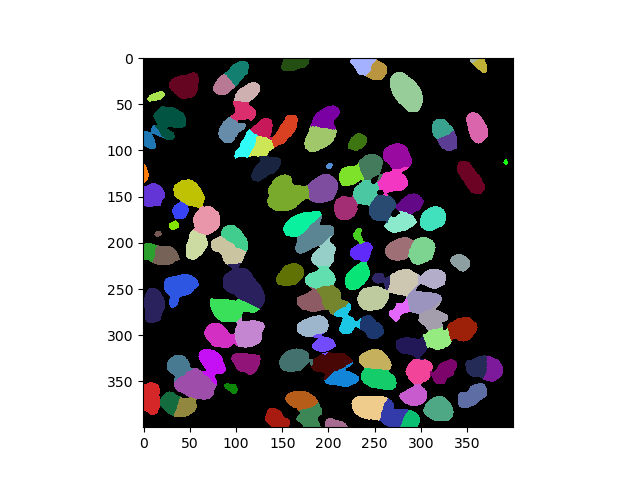

In [4]:
label_image = np.asarray(cle.voronoi_otsu_labeling(background_subtracted_image, spot_sigma=4))

# show result
stackview.insight(label_image)

## Messungen und Merkmalsextraktion
Nachdem das Bild segmentiert ist, können wir Eigenschaften der einzelnen Objekte messen. Diese Eigenschaften sind typischerweise beschreibende statistische Parameter, die als Merkmale bezeichnet werden. Wenn wir Messungen wie die Fläche oder die mittlere Intensität ableiten, extrahieren wir diese beiden Merkmale.

In [5]:
statistics = measure.regionprops_table(label_image, 
                                       intensity_image=cropped_image,
                                       properties=('area', 'mean_intensity', 'major_axis_length', 'minor_axis_length'))

## Arbeiten mit Tabellen
Das oben erstellte `statistics`-Objekt enthält eine Python-Datenstruktur, ein Wörterbuch von Messvektoren, was nicht am intuitivsten zu betrachten ist. Daher konvertieren wir es in eine Tabelle. Datenwissenschaftler nennen diese Tabellen oft DataFrames, die in der [pandas](https://pandas.pydata.org/)-Bibliothek verfügbar sind.

In [6]:
dataframe = pd.DataFrame(statistics)

Wir können bestehende Tabellenspalten verwenden, um andere Messungen zu berechnen, wie zum Beispiel das `aspect_ratio`.

In [7]:
dataframe['aspect_ratio'] = dataframe['major_axis_length'] / dataframe['minor_axis_length']
dataframe

area  mean_intensity  major_axis_length  minor_axis_length  aspect_ratio
0    294.0    36604.625850          25.656180          18.800641      1.364644
1     91.0    37379.769231          20.821990           6.053507      3.439658
2    246.0    44895.308943          21.830827          14.916032      1.463581
3    574.0    44394.637631          37.788705          19.624761      1.925563
4    518.0    45408.903475          26.917447          24.872908      1.082199
..     ...             ...                ...                ...           ...
108  568.0    48606.121479          37.357606          19.808121      1.885974
109  175.0    25552.074286          17.419031          13.675910      1.273702
110  460.0    39031.419565          26.138592          23.522578      1.111213
111  407.0    39343.292383          28.544027          19.563792      1.459023
112   31.0    29131.322581           6.892028           5.711085      1.206781

[113 rows x 5 columns]

## Plotten
Messungen können mithilfe von Diagrammen visualisiert werden.

<Axes: xlabel='area', ylabel='aspect_ratio'>

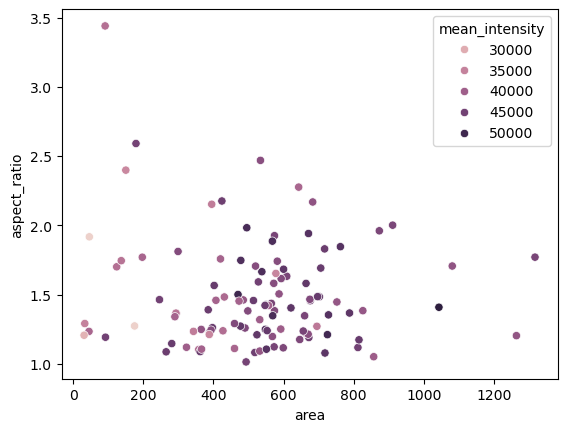

In [8]:
seaborn.scatterplot(dataframe, x='area', y='aspect_ratio', hue='mean_intensity')

## Deskriptive Statistik
Ausgehend von dieser Tabelle können wir Statistiken verwenden, um einen Überblick über die gemessenen Daten zu erhalten.

In [9]:
mean_area = np.mean(dataframe['area'])
stddev_area = np.std(dataframe['area'])

print("Die durchschnittliche Zellkernfläche beträgt", mean_area, "+-", stddev_area, "Pixel")

Mean nucleus area is 524.4247787610619 +- 231.74703195433014 pixels


## Klassifizierung
Für ein besseres Verständnis der internen Struktur von Geweben, aber auch zur Korrektur von Artefakten in Bildverarbeitungs-Workflows, können wir Zellen klassifizieren, zum Beispiel nach ihrer Größe und Form.

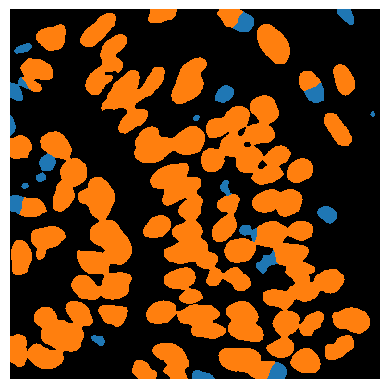

In [10]:
object_classifier = apoc.ObjectClassifier('../../data/blobs_classifier.cl')
classification_image = object_classifier.predict(label_image, cropped_image)

stackview.imshow(classification_image)